<h2>File ingestion and schema validation project</h2>

Name: Margarita Prokhorovich, Batch code: LISUM09

In this project, I conduct file ingestion and schema validation algorythms. I take file with size about 2GB with data about high-energy experiment. Data description is provided [here](https://sdm.lbl.gov/fastbit/data/samples.html), list of columns is provided [here](https://sdm.lbl.gov/fastbit/data/README-star2002.txt). Since column names are separate from dataframe itself, I need to process data with column names and create a list of columns. 

In [ ]:
#import module
import requests
#process file data
resp = requests.get('https://sdm.lbl.gov/fastbit/data/README-star2002.txt')
list_head = resp.text.split('\n')
list_head = list_head[1:17]
list_head = [item.split('\t')[0] for item in list_head]

After downloading the data we upload it to Google drive, since it will be easier to work with a large file in the cloud. Also there's an option to upload the file directly to Colab.

In [ ]:
from google.colab import files
uploaded = files.upload()

I uploaded the file to Google Drive. To get access to the file, it's needed to mount the cloud.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Downloaded and uploaded on Google Drive file is a compressed csv file with gzip format. It's needed to uncompress it for further reading.



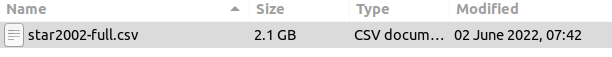

In [ ]:
from IPython.display import Image
Image(filename="/content/gdrive/MyDrive/Week6_project/file.png")

In [ ]:
#import modles
import gzip
import shutil
#open gzip file and write data to a created in Colab csv file.
with gzip.open('/content/gdrive/MyDrive/Week6_project/star2002-full.csv.gz', 'rb') as f_in: 
    with open('star2002-full.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

We also can save the uncopressed csv file to Google Drive.

In [ ]:
pd_df = pd.read_csv('star2002-full.csv')
with open('/content/gdrive/MyDrive/Week6_project/star2002-full1.csv.gz', 'wb') as f: 
   pd_df.to_csv('star2002-full.csv')

The file is ready for further processing. Next step is to create a dataframe. We can create it using differnt options for reading and compare efficiency from time perspective. Reading from csv file has Big-O(N) linear notation, since time spended for proceeding incerases linearly and depends on number of rows in the file. To measure time spended, I create a decorator, which measures the time.

In [ ]:
#import time module
from time import time
  
def timer(func):
    # This function shows the execution time of 
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'\nCode executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

Below I consider options of reading files with Pandas, Dask, Modin and Vaex.
Reading the file with Pandas. I pass as an argument a list of column names.

In [ ]:
@timer
def read_with_pandas():
  import pandas as pd 
  import timeit
  #
  pd_df = pd.read_csv('star2002-full.csv', names = list_head)
  display(pd_df.head(3))

read_with_pandas()

,antiNucleus,eventFile,eventNumber,eventTime,histFile,multiplicity,NaboveLb,NbelowLb,NLb,primaryTracks,prodTime,Pt,runNumber,vertexX,vertexY,vertexZ
0,1,1613423,807,2.001102e+07,1613424,4518,0,0,654,1395,2.001120e+07,10.955403,2288071,-0.288203,0.407312,10.559091
1,1,1613423,808,2.001102e+07,1613424,886,0,0,61,371,2.001120e+07,23.326479,2288071,-0.247330,0.455916,57.810596
2,1,1613423,809,2.001102e+07,1613424,638,0,0,7,121,2.001120e+07,2.444299,2288071,-0.390961,0.589534,167.757140



Code executed in 45.7380s


Reading the file with Dask.

In [ ]:
!pip install dask[dataframe] &> /dev/null


In [ ]:
@timer
def read_with_dask():
  import dask.dataframe as dd
  dask_df = dd.read_csv('star2002-full.csv', names = list_head)  
  display(dask_df.head(3))

read_with_dask()

,antiNucleus,eventFile,eventNumber,eventTime,histFile,multiplicity,NaboveLb,NbelowLb,NLb,primaryTracks,prodTime,Pt,runNumber,vertexX,vertexY,vertexZ
0,1,1613423,807,2.001102e+07,1613424,4518,0,0,654,1395,2.001120e+07,10.955403,2288071,-0.288203,0.407312,10.559091
1,1,1613423,808,2.001102e+07,1613424,886,0,0,61,371,2.001120e+07,23.326479,2288071,-0.247330,0.455916,57.810596
2,1,1613423,809,2.001102e+07,1613424,638,0,0,7,121,2.001120e+07,2.444299,2288071,-0.390961,0.589534,167.757140



Code executed in 1.6563s


Reading the file with Modin.

In [ ]:
!pip install modin &> /dev/null
!pip install ray &> /dev/null

In [ ]:
import ray
#ray.shutdown()
ray.init()

RayContext(dashboard_url='', python_version='3.7.13', ray_version='1.12.1', ray_commit='4863e33856b54ccf8add5cbe75e41558850a1b75', address_info={'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-03_03-51-56_032085_3057/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-03_03-51-56_032085_3057/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-06-03_03-51-56_032085_3057', 'metrics_export_port': 58860, 'gcs_address': '172.28.0.2:60610', 'address': '172.28.0.2:60610', 'node_id': '4a30451414330feaf7d761418d102fbced08277f8a661331959c303b'})

In [ ]:
@timer
def read_with_modin():
  import modin.pandas as mpd
  modin_df = mpd.read_csv('star2002-full.csv', names = list_head)
  display(modin_df.head(3))

read_with_modin() 

,antiNucleus,eventFile,eventNumber,eventTime,histFile,multiplicity,NaboveLb,NbelowLb,NLb,primaryTracks,prodTime,Pt,runNumber,vertexX,vertexY,vertexZ
0,1,1613423,807,2.001102e+07,1613424,4518,0,0,654,1395,2.001120e+07,10.955403,2288071,-0.288203,0.407312,10.559091
1,1,1613423,808,2.001102e+07,1613424,886,0,0,61,371,2.001120e+07,23.326479,2288071,-0.247330,0.455916,57.810596
2,1,1613423,809,2.001102e+07,1613424,638,0,0,7,121,2.001120e+07,2.444299,2288071,-0.390961,0.589534,167.757140



Code executed in 44.6053s


Reading the file with Vaex.

In [ ]:
!pip install vaex &> /dev/null

In [ ]:
@timer
def read_with_vaex():  
  import vaex
  vaex_df = vaex.from_csv('star2002-full.csv', names = list_head)
  display(vaex_df.head(3))

read_with_vaex()

#,antiNucleus,eventFile,eventNumber,eventTime,histFile,multiplicity,NaboveLb,NbelowLb,NLb,primaryTracks,prodTime,Pt,runNumber,vertexX,vertexY,vertexZ
0,1,1613423,807,2.0011e+07,1613424,4518,0,0,654,1395,2.00112e+07,10.9554,2288071,-0.288203,0.407312,10.5591
1,1,1613423,808,2.0011e+07,1613424,886,0,0,61,371,2.00112e+07,23.3265,2288071,-0.24733,0.455916,57.8106
2,1,1613423,809,2.0011e+07,1613424,638,0,0,7,121,2.00112e+07,2.4443,2288071,-0.390961,0.589534,167.757



Code executed in 66.9928s


We can see that reading the file with Dask takes the least amount of time. Next step is to create a file that proceeds column names in a dataframe and checks if it matches information in a config file. I apply to column names functions that make all the letters lowercase and insert an underscore between separate words.

In [ ]:
%%writefile testutility.py
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime 
import re

def read_config_file(filepath):
    with open(filepath, 'r') as file:
        try:
            return yaml.safe_load(file)
        except yaml.YAMLError as exc:
            logging.error(exc)

def separate(string):
    res = any(ele.isupper() for ele in string[1:])
    if not str.isupper(string[0]) and res == True:
      pattern = re.search(r'^([^A-Z]*[A-Z]){1}', string)
      ind = pattern.span()[1]-1
      modified_str = string[:ind] + '_' + string[ind:] 
      return modified_str
    elif str.isupper(string[0]) and res == True:
      pattern = re.search(r'^([^A-Z]*[A-Z]){2}', string)
      ind = pattern.span()[1]-1
      modified_str = string[:ind] + '_' + string[ind:] 
      return modified_str
    else:
      pattern = re.search(r'^([^A-Z]*[A-Z]){1}', string)
      return string 

def col_header_val(df,table_config):
    '''
    replace whitespaces in the column
    and standardized column names
    '''
    df.columns = list(map(lambda x: separate(x), list(df.columns)))
    df.columns = df.columns.str.lower()
 
    expected_col = list(map(lambda x: x.lower(),  table_config['columns']))
    expected_col.sort()
    df.columns =list(map(lambda x: x.lower(), list(df.columns)))
    df = df.reindex(sorted(df.columns), axis=1)
    
    if len(df.columns) == len(expected_col) and list(expected_col)  == list(df.columns):
        print("column name and column length validation passed")
        return 1
    else:
        print("column name and column length validation failed")
        mismatched_columns_file = list(set(df.columns).difference(expected_col))
        print("Following File columns are not in the YAML file",mismatched_columns_file)
        missing_YAML_file = list(set(expected_col).difference(df.columns))
        print("Following YAML columns are not in the file uploaded",missing_YAML_file)
        logging.info(f'df columns: {df.columns}')
        logging.info(f'expected columns: {expected_col}')
        return 0

Writing testutility.py


It's needed to write a YAML file to specify the file schema. I mention file type, name, delimiters, final column names, etc.

In [ ]:
%%writefile file.yaml
file_type: csv
file_name: star2002-full
inbound_delimiter: ","
outbound_delimiter: "|"
skip_leading_rows: 0
columns: 
    - anti_nucleus
    - event_file
    - event_number
    - event_time
    - hist_file
    - multiplicity
    - nabove_lb
    - nbelow_lb
    - n_lb
    - primary_tracks
    - prod_time
    - pt
    - run_number
    - vertex_x
    - vertex_y
    - vertex_z

Overwriting file.yaml


In [ ]:
# Read config file
import testutility as util
config_data = util.read_config_file("file.yaml")

In [ ]:
#print config data
config_data

{'file_type': 'csv',
 'file_name': 'star2002-full',
 'inbound_delimiter': ',',
 'outbound_delimiter': '|',
 'skip_leading_rows': 0,
 'columns': ['anti_nucleus',
  'event_file',
  'event_number',
  'event_time',
  'hist_file',
  'multiplicity',
  'nabove_lb',
  'nbelow_lb',
  'n_lb',
  'primary_tracks',
  'prod_time',
  'pt',
  'run_number',
  'vertex_x',
  'vertex_y',
  'vertex_z']}

After creating the config file I should choose the fastest option for reading and further validation of the file. Since using Dask is the fastest one but Dask dataframe has not attribute 'reindex', I choose to read the file with Dask and convert it to pandas dataframe using 'compute' method. We can see that reading with Dask and and converting to pandas df runs faster than just reading with Modin, Vaex and Pandas.

In [ ]:
#reading dataframe with Dask and converting to pandas dataframe object
@timer
def read_df_dask():
  import dask.dataframe as dd
  # read the file using config file
  file_type = config_data['file_type']
  source_file = "./" + config_data['file_name'] + f'.{file_type}'
  global df_dask_to_pd
  df_dask_to_pd = dd.read_csv(source_file,names = list_head, delimiter = config_data['inbound_delimiter']).compute() #.compute()
  display(df_dask_to_pd.head(3))

read_df_dask()

,antiNucleus,eventFile,eventNumber,eventTime,histFile,multiplicity,NaboveLb,NbelowLb,NLb,primaryTracks,prodTime,Pt,runNumber,vertexX,vertexY,vertexZ
0,1,1613423,807,2.001102e+07,1613424,4518,0,0,654,1395,2.001120e+07,10.955403,2288071,-0.288203,0.407312,10.559091
1,1,1613423,808,2.001102e+07,1613424,886,0,0,61,371,2.001120e+07,23.326479,2288071,-0.247330,0.455916,57.810596
2,1,1613423,809,2.001102e+07,1613424,638,0,0,7,121,2.001120e+07,2.444299,2288071,-0.390961,0.589534,167.757140


Code executed in 31.4915s


In [ ]:
import warnings
warnings.filterwarnings('ignore')

#reading dataframe with pandas, cab see that it takes longer time
@timer
def read_df_pd():
  import pandas as pd  
  # read the file using config file
  file_type = config_data['file_type']
  source_file = "./" + config_data['file_name'] + f'.{file_type}'
  global df_pd 
  df_pd = pd.read_csv(source_file,config_data['inbound_delimiter'], names = list_head)
  display(df_pd.head(3))

read_df_pd()

,antiNucleus,eventFile,eventNumber,eventTime,histFile,multiplicity,NaboveLb,NbelowLb,NLb,primaryTracks,prodTime,Pt,runNumber,vertexX,vertexY,vertexZ
0,1,1613423,807,2.001102e+07,1613424,4518,0,0,654,1395,2.001120e+07,10.955403,2288071,-0.288203,0.407312,10.559091
1,1,1613423,808,2.001102e+07,1613424,886,0,0,61,371,2.001120e+07,23.326479,2288071,-0.247330,0.455916,57.810596
2,1,1613423,809,2.001102e+07,1613424,638,0,0,7,121,2.001120e+07,2.444299,2288071,-0.390961,0.589534,167.757140



Code executed in 43.5469s


In [ ]:
#validate the header of the file
util.col_header_val(df_dask_to_pd,config_data)

column name and column length validation passed


1

In [ ]:
print("columns of files are:" , list(df_dask_to_pd.columns))
print("columns of YAML are:" ,config_data['columns'])
if util.col_header_val(df_dask_to_pd,config_data)==0:
    print("validation failed")
    # write code to reject the file
else:
    print("col validation passed")

columns of files are: ['anti_nucleus', 'event_file', 'event_number', 'event_time', 'hist_file', 'multiplicity', 'nabove_lb', 'nbelow_lb', 'n_lb', 'primary_tracks', 'prod_time', 'pt', 'run_number', 'vertex_x', 'vertex_y', 'vertex_z']
columns of YAML are: ['anti_nucleus', 'event_file', 'event_number', 'event_time', 'hist_file', 'multiplicity', 'nabove_lb', 'nbelow_lb', 'n_lb', 'primary_tracks', 'prod_time', 'pt', 'run_number', 'vertex_x', 'vertex_y', 'vertex_z']
column name and column length validation passed
col validation passed


In [ ]:
#write the dataframe to txt file
df_dask_to_pd.to_csv('treated_data.txt', sep = config_data['outbound_delimiter'])

In [ ]:
#show a part of the file
with open('treated_data.txt', 'r') as f_in:
  resp = f_in.read()
  print(resp[:500])

#compress txt file using gzip
import gzip
with open('treated_data.txt', 'rb') as f_in:
  with open('/content/gdrive/MyDrive/Week6_project/treated_data.txt.gz', 'wb') as f_out:
     f_out.writelines(f_in)


|anti_nucleus|event_file|event_number|event_time|hist_file|multiplicity|nabove_lb|nbelow_lb|n_lb|primary_tracks|prod_time|pt|run_number|vertex_x|vertex_y|vertex_z
0|1|1613423|807|20011015.222604|1613424|4518|0|0|654|1395|20011204.114951|10.955403|2288071|-0.28820264|0.40731233|10.559091
1|1|1613423|808|20011015.222604|1613424|886|0|0|61|371|20011204.115313|23.326479|2288071|-0.24732992|0.45591551|57.810596
2|1|1613423|809|20011015.222604|1613424|638|0|0|7|121|20011204.115355|2.4442992|2288071|-0


In [ ]:
#define function that displays summary of the file
def file_summary(filepath):
  import csv
  import os

  with open(filepath,'r') as f:
    reader = csv.reader(f, delimiter='|', skipinitialspace=True)
    first_row = next(reader)
    num_cols = len(first_row)
    row_count = sum(1 for row in f)

  print(f"Number of columns is {num_cols-1}")
  print(f"Number of rows is {row_count}")
  print(f"File size is {round(os.path.getsize(filepath)/1000000,3)} MB")

file_summary('/content/gdrive/MyDrive/Week6_project/treated_data.txt.gz')

Number of columns is 16
Number of rows is 15857625
File size is 1925.403 MB


References:
1. [Sample Datasets from STAR Experiment](https://sdm.lbl.gov/fastbit/data/samples.html)

2. [Scaling Pandas: Comparing Dask, Ray, Modin, Vaex, and RAPIDS](https://www.datarevenue.com/en-blog/pandas-vs-dask-vs-vaex-vs-modin-vs-rapids-vs-ray) 

3. [Dask](https://dask.org/)

4. [Scale your pandas workflow by changing a single line of code](https://modin.readthedocs.io/en/stable/)

5. [Ray Datasets: Distributed Data Loading and Compute](https://docs.ray.io/en/latest/data/dataset.html)

6. [What is Vaex?](https://vaex.io/docs/index.html)

7. [Timing Functions With Decorators – Python](https://www.geeksforgeeks.org/timing-functions-with-decorators-python/)
